## WFP-01-03-02 CHIRPS Rainfall Estimates (RFE) - Aggregations

 This application generates Rainfall Estimates (RFE) aggregations, from CHIRPS RFE 5km resolution, compared to a reference period.

### <a name="quicklink">Quick link

* [Objective](#objective)
* [Test Site](#test-site)
* [Context](#context)
* [Applicability](#applicability)
* [Data](#data)
* [Service Definition](#service)
* [Parameter Definition](#parameter)
* [Runtime Parameter Definition](#runtime)
* [Workflow](#workflow)
* [Strengths and Limitations](#strengths-limitations) 
* [License](#license)

### <a name="objective">Objective 

The objective of this code is to determine:
    - Sum of daily data over the past N days, derived every 10 days (N = 10, 30, 60, 90, 120, 150, 180, 270, 365 days)
    - Counts of daily data above 1mm over the past N days, derived every 10 days (N = 30, 60, 90 days).
    - Longest sequence of daily values < 2mm ("dry spell") within the last N days, derived every 10 days (N = 30, 60, 90 days).

### <a name="testsite">Methodology

We apply here the principles descrbed by [Hostache et al., 2012, Change detection approaches for flood extent mapping: How to select the most adequate reference image from online archives?](https://www.researchgate.net/publication/230627460_Change_detection_approaches_for_flood_extent_mapping_How_to_select_the_most_adequate_reference_image_from_online_archives)


### <a name="testsite">Test Site

Mopti (Mali)

### <a name="context">Context

The practice was applied to the flood event in Mopti in July 2016.

### <a name="applicability">Applicability

This practice can be applied globally. It will be applied as input for a correlated search in the catalog allowing to identify rapidly a reference image for a flooding image.


### <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

### <a name="service">Service definition

In [ ]:
service = dict([('title', 'CHIRPS Rainfall Estimates (RFE) - Aggregations'),
                ('abstract', 'TBD'),
                ('id', 'ewf-notebook-stagein-2')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the CHIRPS stack of products' identifiers

In [1]:
input_identifiers = ('chirps-v2.0.2018.09.28.tif.gz', 'chirps-v2.0.2018.09.27.tif.gz', 'chirps-v2.0.2018.09.26.tif.gz', 'chirps-v2.0.2018.09.25.tif.gz')
region_of_interest = 'POLYGON((-30 -10, 20 -10, 20 40, -30 40, -30 -10))'

**Input references**

This is the CHIRPS stack catalogue references

In [2]:
input_references = ('ftp://ftp.chg.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2018/chirps-v2.0.2018.09.28.tif.gz', 'ftp://ftp.chg.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2018/chirps-v2.0.2018.09.27.tif.gz', 'ftp://ftp.chg.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2018/chirps-v2.0.2018.09.26.tif.gz', 'ftp://ftp.chg.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2018/chirps-v2.0.2018.09.25.tif.gz') 

**Data path**

This path defines where the data is staged-in. 

In [3]:
data_path = "/workspace/data/chirps-2.0/"
unzipped_chirps_path = "/workspace/data/chirps-2.0/unzipped_chirps/"

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [4]:
from osgeo import gdal
import gzip
import shutil
import numpy as np
from aux_functions import matrix_sum, mask_matrix, crop_image, write_output_image

#### Read the products

In [ ]:
products = []
mask_no_data_value = 0
sum_result = 0
count_above_one = 0
max_sequence = 0
temp_mat = 0
for chirp_product_url in input_references:
    # uncompressed data
    chirp_product = chirp_product_url.split('/')[-1]
    # unzipped_product = unzipped_chirps_path + chirp_product.split('.gz')[0]
    # with gzip.open(zipped_product, 'rb') as f_in:
    #     with open(unzipped_product, 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)
    # Crop the image according to the region of interest
    cropped_product_path = data_path + 'crop_' + chirp_product
    crop_image(chirp_product_url, region_of_interest, cropped_product_path)
    # Read GeoTIFF as an array
    dataset = gdal.Open(cropped_product_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    no_data_value = dataset.GetRasterBand(1).ComputeRasterMinMax()[0]
    ## Create mask of no_data_values
    if isinstance(mask_no_data_value, int):
        mask_no_data_value = np.where(product_array == no_data_value, 1, 0)
    else:
        temp_mask = np.where(product_array == no_data_value, 1, 0)
        mask_no_data_value = matrix_sum(mask_no_data_value, temp_mask)
    
    ## Create iteratively the sum array
    sum_result = matrix_sum(sum_result, product_array, no_data_value)
    
    ## Create iteratively the array with the counts of daily data above 1mm
    regions_above_one = mask_matrix(product_array, 1, True, no_data_value)
    count_above_one = matrix_sum(count_above_one, regions_above_one)
    
    ## Create iteratively the array with the longest sequence of daily values <2mm
    regions_below_two = mask_matrix(product_array, 2, False, no_data_value)
    temp_mat = matrix_sum(temp_mat, regions_below_two)
    if isinstance(max_sequence, int):
        max_sequence = temp_mat
    max_sequence[regions_below_two == 0] = np.maximum(max_sequence[regions_below_two == 0], temp_mat[regions_below_two == 0])
    temp_mat[regions_below_two == 0] = 0
    

    
print(np.unique(mask_no_data_value, return_counts=True))    
print(np.unique(sum_result))
print(np.unique(count_above_one, return_counts=True))
print(np.unique(max_sequence, return_counts=True))

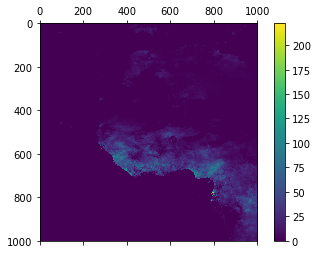

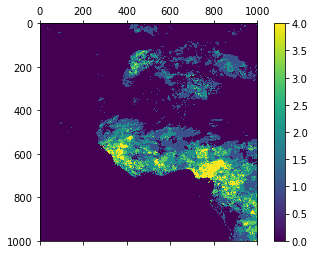

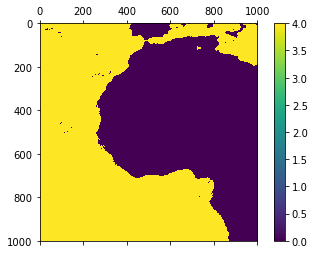

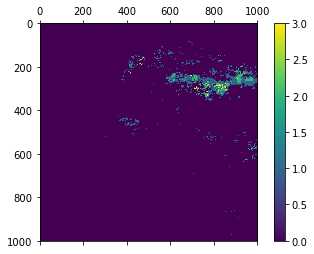

In [7]:
from matplotlib import pyplot
%matplotlib inline


fig0 = pyplot.figure()
ax0 = fig0.add_subplot(111)
cax0 = ax0.matshow(sum_result)
fig0.colorbar(cax0)

fig1 = pyplot.figure()
ax1 = fig1.add_subplot(111)
cax1 = ax1.matshow(count_above_one)
fig1.colorbar(cax1)


fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mask_no_data_value)
fig.colorbar(cax)


fig2 = pyplot.figure()
ax2 = fig2.add_subplot(111)
cax2 = ax2.matshow(max_sequence)
fig2.colorbar(cax2)

pyplot.show()

#### Write Output GeoTIFFs:

In [ ]:
outpath = data_path + 'outputs/'
image_format = "GTiff"
num_days = len(input_identifiers)
write_output_image(outpath + str(num_days) + 'days_total.tif', sum_result, image_format, mask_no_data_value)
write_output_image(outpath + str(num_days) + 'days_above_one.tif', count_above_one, image_format, mask_no_data_value)
write_output_image(outpath + str(num_days) + 'days_dry_spell.tif', max_sequence, image_format, mask_no_data_value)